In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from pathlib import Path


In [2]:
#import data
coffee_data = Path('Resources/coffee-shop-sales-revenue.csv')

print(coffee_data)

Resources\coffee-shop-sales-revenue.csv


In [3]:
#Read in the data
coffee_df = pd.read_csv(coffee_data, sep='|')

#Print out the first and last five rows
display(coffee_df.head(2))
display(coffee_df.tail(2))

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup


In [4]:
#Clean the data

#Check for nulls
display(coffee_df.isnull().mean() * 100)

#remove nulls
coffee_df = coffee_df.dropna()

#Check for duplicates
display(coffee_df.duplicated().sum())

#Remove duplicates
coffee_df = coffee_df.drop_duplicates()

#Combine date and time columns into new column
coffee_df['salesdatetime'] = coffee_df['transaction_date'].astype(str) + ' ' + coffee_df['transaction_time'].astype(str)

#Convert new column to datetime
coffee_df['salesdatetime'] = pd.to_datetime(coffee_df['salesdatetime'])

#Check data types
display(coffee_df.dtypes)

#Print out the first and last five rows
display(coffee_df.head(2))
display(coffee_df.tail(2))


transaction_id      0.0
transaction_date    0.0
transaction_time    0.0
transaction_qty     0.0
store_id            0.0
store_location      0.0
product_id          0.0
unit_price          0.0
product_category    0.0
product_type        0.0
product_detail      0.0
dtype: float64

0

transaction_id               int64
transaction_date            object
transaction_time            object
transaction_qty              int64
store_id                     int64
store_location              object
product_id                   int64
unit_price                 float64
product_category            object
product_type                object
product_detail              object
salesdatetime       datetime64[ns]
dtype: object

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19


In [5]:
#Create a new column for total sales
coffee_df['totalsales'] = coffee_df['transaction_qty'] * coffee_df['unit_price']

#Create a new column for month
coffee_df['month'] = coffee_df['salesdatetime'].dt.month

#print(coffee_df['month'])
#print(coffee_df['salesdatetime'].dt.year)
#print(coffee_df['salesdatetime'].dt.day)
#Create a new column for the week of the year
coffee_df['weekofyear'] = pd.to_datetime(coffee_df['salesdatetime']).dt.strftime('%U')

#Create a new column for day of week
coffee_df['dayofweek'] = coffee_df['salesdatetime'].dt.dayofweek

#Create a new column for hour
coffee_df['hour'] = coffee_df['salesdatetime'].dt.hour

#Print out the first and last 2 rows
display(coffee_df.head(2))
display(coffee_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11,6.0,1,01,6,7
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19,3.75,6,26,4,20
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19,1.60,6,26,4,20


In [6]:
#Create a dataframe for each store
store1_df = coffee_df.loc[coffee_df['store_id'] == 3]
store2_df = coffee_df.loc[coffee_df['store_id'] == 5]
store3_df = coffee_df.loc[coffee_df['store_id'] == 8]

#Reset the index for each store to sale datetime
store1_df = store1_df.set_index('salesdatetime')
store2_df = store2_df.set_index('salesdatetime')
store3_df = store3_df.set_index('salesdatetime')


#Print out the first and last 2 rows of each store
display(store1_df.head(2))
display(store1_df.tail(2))

display(store2_df.head(2))
display(store2_df.tail(2))

display(store3_df.head(2))
display(store3_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 11:01:48,106,2023-01-01,11:01:48,1,3,Astoria,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.00,1,01,6,11
2023-01-01 11:01:58,107,2023-01-01,11:01:58,1,3,Astoria,38,3.75,Coffee,Barista Espresso,Latte,3.75,1,01,6,11


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:57:49,149448,2023-06-30,19:57:49,2,3,Astoria,54,2.50,Tea,Brewed Chai tea,Morning Sunrise Chai Rg,5.00,6,26,4,19
2023-06-30 19:57:49,149449,2023-06-30,19:57:49,1,3,Astoria,70,3.25,Bakery,Scone,Cranberry Scone,3.25,6,26,4,19


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 07:06:11,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,1,01,6,7
2023-01-01 07:08:56,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:40:09,149435,2023-06-30,19:40:09,2,5,Lower Manhattan,58,3.5,Drinking Chocolate,Hot chocolate,Dark chocolate Rg,7.0,6,26,4,19
2023-06-30 20:16:31,149451,2023-06-30,20:16:31,2,5,Lower Manhattan,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,5.0,6,26,4,20


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 08:00:18,18,2023-01-01,08:00:18,1,8,Hell's Kitchen,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,2.5,1,01,6,8
2023-01-01 08:00:39,19,2023-01-01,08:00:39,2,8,Hell's Kitchen,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,1,01,6,8


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 20:57:19,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,3.75,6,26,4,20
2023-06-30 20:57:19,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,1.60,6,26,4,20


In [7]:
#Create a custom function to sum total sales
def sum_totalsales(df):
    return df['totalsales'].sum()

#create a custom function to calculate average sales
def avg_totalsales(df):
    return df['totalsales'].mean()


In [8]:
#Create a dataframe for each store's total sales using the custom function by month
store1_totalsales = store1_df.groupby('month').apply(sum_totalsales)
store2_totalsales = store2_df.groupby('month').apply(sum_totalsales)
store3_totalsales = store3_df.groupby('month').apply(sum_totalsales)

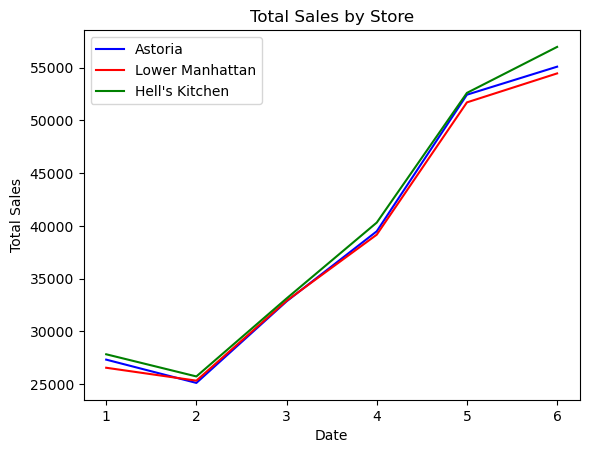

<Figure size 6000x1000 with 0 Axes>

In [9]:
#Dispalay the total sales for each store as a line graph
plt.plot(store1_totalsales, label='Astoria', color='blue')
plt.plot(store2_totalsales, label='Lower Manhattan', color='red')
plt.plot(store3_totalsales, label="Hell's Kitchen", color='green')


plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

plt.show()


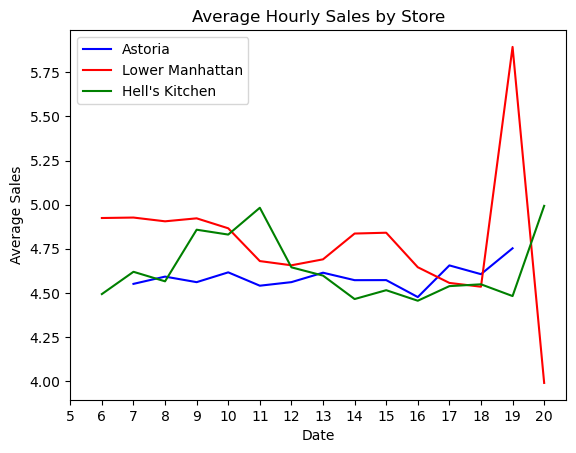

<Figure size 6000x1000 with 0 Axes>

In [36]:
#Create a dataframe for each store's average sales using the custom function by hour
store1_avgsales = store1_df.groupby('hour').apply(avg_totalsales)
store2_avgsales = store2_df.groupby('hour').apply(avg_totalsales)
store3_avgsales = store3_df.groupby('hour').apply(avg_totalsales)

#Dispalay the average sales for each store as a line graph
plt.plot(store1_avgsales, label='Astoria', color='blue')
plt.plot(store2_avgsales, label='Lower Manhattan', color='red')
plt.plot(store3_avgsales, label="Hell's Kitchen", color='green')

#Change the x axis to display hours as 12 hour time label starting at 6am and ending at 8pm
plt.xticks(np.arange(5, 21, 1))


plt.xlabel('Time of Day')
plt.ylabel('Average Sales')
plt.title('Average Hourly Sales by Store')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

plt.show()



<Figure size 6000x1000 with 0 Axes>

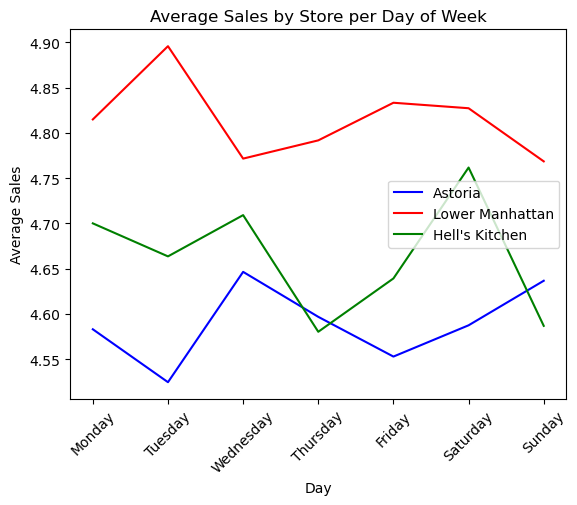

<Figure size 6000x1000 with 0 Axes>

In [15]:
#Create a dataframe for each store's average sales using the custom function by day of week
store1_avgsales = store1_df.groupby('dayofweek').apply(avg_totalsales)
store2_avgsales = store2_df.groupby('dayofweek').apply(avg_totalsales)
store3_avgsales = store3_df.groupby('dayofweek').apply(avg_totalsales)

#Dispalay the average sales for each store as a line graph
plt.plot(store1_avgsales, label='Astoria', color='blue')
plt.plot(store2_avgsales, label='Lower Manhattan', color='red')
plt.plot(store3_avgsales, label="Hell's Kitchen", color='green')

#Change the x axis labels to day of week names
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=45)

plt.xlabel('Day')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store per Day of Week')
plt.legend(loc='best')
plt.figure(figsize=(60,10))
